# EJERCICIOS

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import joblib
import seaborn as sns
from sklearn.datasets import load_digits
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MultiLabelBinarizer, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve,confusion_matrix,make_scorer,ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.svm import SVC 
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc, accuracy_score
from scipy.stats import reciprocal,uniform, randint
from sklearn.feature_extraction.text import TfidfVectorizer

## EJERCICIO 1

Vamos a trabajar con el siguiente conjunto de datos: https://www.datacamp.com/es/datalab/datasets/dataset-python-loans

| Variable      	| Explicación                                                                                                             |
|-------------------|-------------------------------------------------------------------------------------------------------------------------|
| credit_policy	    | 1 si el cliente cumple con los criterios de suscripción de crédito; 0 en caso contrario.                                |
| purpose	        | El propósito del préstamo.                                                                                              |
| int_rate	        | La tasa de interés del préstamo (a los prestatarios más riesgosos se les asignan tasas más altas).                      |
| installment	    | Las cuotas mensuales del prestamo                                                                                       |
| log_annual_inc    | El logaritmo natural del ingreso anual declarado por el prestatario.                                                    |
| dti	            | La relación deuda-ingreso del prestatario (monto de deuda dividido por ingresos anuales).                               |
| fico	            | El puntaje de crédito FICO del prestatario.                                                                             |
| days_with_cr_line	| El número de días que el prestatario ha tenido una línea de crédito.                                                    |
| revol_bal	        | El saldo rotativo del prestatario (monto no pagado al final del ciclo de facturación de la tarjeta).                    |
| revol_util        | La tasa de utilización de la línea de crédito del prestatario (monto de crédito utilizado respecto al total disponible).|
| inq_last_6mths	| El número de consultas de los acreedores al prestatario en los últimos 6 meses.                                         |
| delinq_2yrs	    | El número de veces que el prestatario ha estado más de 30 días en mora en un pago en los últimos 2 años.                |
| pub_rec	        | El número de registros públicos despectivos del prestatario.                                                            |
| not_fully_paid    | 1 si el préstamo se pagó totalmente; 0 en caso contrario.                                                        |

El csv lo tienes disponible en Moodle

Este conjunto de datos consta de más de 9500 préstamos con información sobre los datos del préstamo y si el préstamo fue pagado en su totalidad o no. Estos datos fueron extraídos de LendingClub.com
Crea un clasificador para predecir si un prestamo va a ser pagado o no.

### RECOPILACIÓN Y PREPARACIÓN DE LOS DATOS

#### OBTENER LOS DATOS

In [19]:
loan_data = pd.read_csv("datos/loan_data.csv")

#### EXPLORAR LOS DATOS

Entre otras cosas: estadísticas, matriz de correlaciones y borrar columnas innecesarias.

In [20]:
loan_data.head()

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


In [21]:
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit.policy      9578 non-null   int64  
 1   purpose            9578 non-null   object 
 2   int.rate           9578 non-null   float64
 3   installment        9578 non-null   float64
 4   log.annual.inc     9578 non-null   float64
 5   dti                9578 non-null   float64
 6   fico               9578 non-null   int64  
 7   days.with.cr.line  9578 non-null   float64
 8   revol.bal          9578 non-null   int64  
 9   revol.util         9578 non-null   float64
 10  inq.last.6mths     9578 non-null   int64  
 11  delinq.2yrs        9578 non-null   int64  
 12  pub.rec            9578 non-null   int64  
 13  not.fully.paid     9578 non-null   int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 1.0+ MB


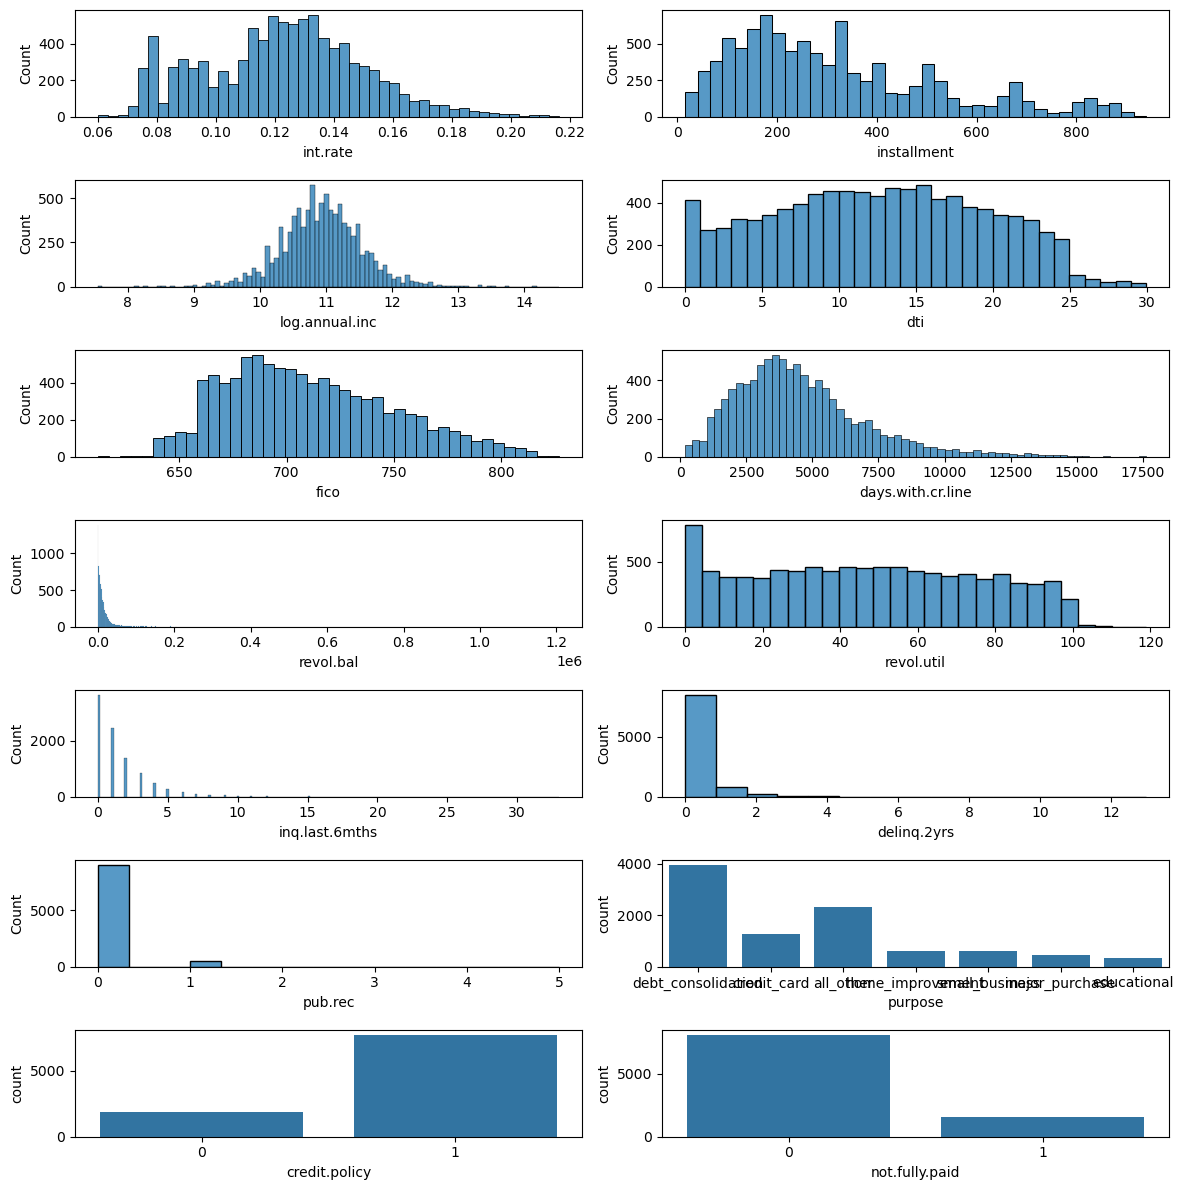

In [22]:
df_object = loan_data.select_dtypes(include=["object","category"]).columns.to_list()
df_num = loan_data.select_dtypes(include=[np.number]).columns.to_list()

df_num.remove("credit.policy")
df_num.remove("not.fully.paid")

df_object.append("credit.policy")
df_object.append("not.fully.paid")
plt.figure(figsize=(12,12))

subplot_index=1

for col in df_num:
    plt.subplot(7,2,subplot_index)
    sns.histplot(x=loan_data[col])
    subplot_index+=1

for col in df_object:
    plt.subplot(7,2,subplot_index)
    sns.countplot(x=loan_data[col])
    subplot_index+=1



plt.tight_layout()
plt.show()

In [23]:
corr_matrix = loan_data.corr(numeric_only=True)
corr_matrix['not.fully.paid'].sort_values(ascending=False)

not.fully.paid       1.000000
int.rate             0.159552
inq.last.6mths       0.149452
revol.util           0.082088
revol.bal            0.053699
installment          0.049955
pub.rec              0.048634
dti                  0.037362
delinq.2yrs          0.008881
days.with.cr.line   -0.029237
log.annual.inc      -0.033439
fico                -0.149666
credit.policy       -0.158119
Name: not.fully.paid, dtype: float64

In [24]:
corr_matrix.style.background_gradient()

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
credit.policy,1.000000,-0.294089,0.058770,0.034906,-0.090901,0.348319,0.099026,-0.187518,-0.104095,-0.535511,-0.076318,-0.054243,-0.158119
int.rate,-0.294089,1.000000,0.276140,0.056383,0.220006,-0.714821,-0.124022,0.092527,0.464837,0.202780,0.156079,0.098162,0.159552
installment,0.058770,0.276140,1.000000,0.448102,0.050202,0.086039,0.183297,0.233625,0.081356,-0.010419,-0.004368,-0.032760,0.049955
log.annual.inc,0.034906,0.056383,0.448102,1.000000,-0.054065,0.114576,0.336896,0.372140,0.054881,0.029171,0.029203,0.016506,-0.033439
dti,-0.090901,0.220006,0.050202,-0.054065,1.000000,-0.241191,0.060101,0.188748,0.337109,0.029189,-0.021792,0.006209,0.037362
fico,0.348319,-0.714821,0.086039,0.114576,-0.241191,1.000000,0.263880,-0.015553,-0.541289,-0.185293,-0.216340,-0.147592,-0.149666
days.with.cr.line,0.099026,-0.124022,0.183297,0.336896,0.060101,0.263880,1.000000,0.229344,-0.024239,-0.041736,0.081374,0.071826,-0.029237
revol.bal,-0.187518,0.092527,0.233625,0.372140,0.188748,-0.015553,0.229344,1.000000,0.203779,0.022394,-0.033243,-0.031010,0.053699
revol.util,-0.104095,0.464837,0.081356,0.054881,0.337109,-0.541289,-0.024239,0.203779,1.000000,-0.013880,-0.042740,0.066717,0.082088
inq.last.6mths,-0.535511,0.202780,-0.010419,0.029171,0.029189,-0.185293,-0.041736,0.022394,-0.013880,1.000000,0.021245,0.072673,0.149452


#### DIVIDIR LOS DATOS

In [25]:
loan_data=loan_data.drop(["delinq.2yrs", "days.with.cr.line", "log.annual.inc","dti"], axis=1)
#Eliminamos las columnas que estan menos correlacionadas con not.fully.paid
train_set, test_set = train_test_split(loan_data, test_size=0.20,stratify=loan_data['purpose'], random_state=42)

#### PREPARAR LOS DATOS

In [26]:
num_pipeline = make_pipeline(
     SimpleImputer(strategy="mean"),
     StandardScaler())

log_pipeline = make_pipeline(
    SimpleImputer(strategy="mean"),
    FunctionTransformer(np.log,feature_names_out="one-to-one"),
    StandardScaler())

purpose_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder())

preprocessing = ColumnTransformer([
    ("purpose_transform", purpose_pipeline, ["purpose"]),
    ("int.rate_transform", log_pipeline, ["int.rate"]),
    ("fico_transform", log_pipeline, ["fico"]),
] ,remainder=num_pipeline, verbose_feature_names_out = False)


### ENTRENAMIENTO Y EVALUACIÓN DEL MODELO

Usa evaluación cruzada con los siguientes algoritmos:
- Regresión logisitca
- SGDClassifier
- K vecinos mas cercanos
- Random Forest

 y evalua los resultados en el conjunto de entrenamiento con las siguientes métricas: exactitud, prescisión, sensibilidad, f1, curva de roc y área bajo la curva de roc

In [27]:
# Separamos columnas
x_train= train_set.drop(columns=["not.fully.paid"])
y_train= train_set["not.fully.paid"].copy()

x_test= test_set.drop(columns=["not.fully.paid"])
y_test= test_set["not.fully.paid"].copy()

Regresión logisitca
Matriz de confusion:
[[6400   32]
 [1195   35]]
Exactitud: 0.8398590446358654
Precision: 0.5223880597014925
Sensibilidad: 0.028455284552845527
F1: 0.05397070161912105
AUC: 0.678968344254338


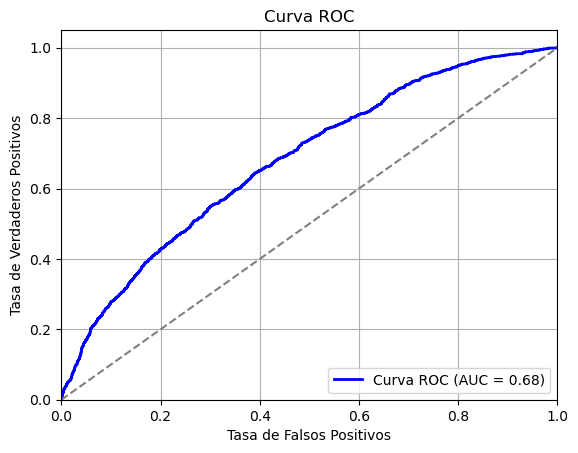

SGDClassifier
Matriz de confusion:
[[6426    6]
 [1227    3]]
Exactitud: 0.8390759592795615
Precision: 0.3333333333333333
Sensibilidad: 0.0024390243902439024
F1: 0.004842615012106538
AUC: 0.4759437062654208


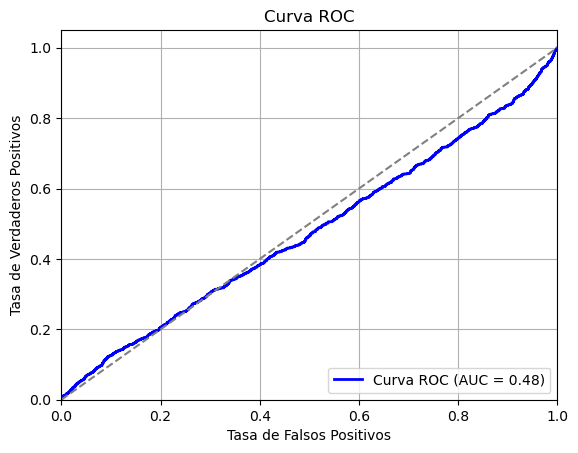

K vecinos mas cercanos
Matriz de confusion:
[[6009  423]
 [1076  154]]
Exactitud: 0.8043591751500914
Precision: 0.2668977469670711
Sensibilidad: 0.12520325203252033
F1: 0.17044825677919204
Random Forest
Matriz de confusion:
[[6371   61]
 [1190   40]]
Exactitud: 0.83672670321065
Precision: 0.39603960396039606
Sensibilidad: 0.032520325203252036
F1: 0.06010518407212622


In [28]:
models={
    "Regresión logisitca": LogisticRegression(random_state=42),
    "SGDClassifier": SGDClassifier(random_state=42),
    "K vecinos mas cercanos": KNeighborsClassifier(n_neighbors=3),
    "Random Forest": RandomForestClassifier(random_state=42),
}

for name, algoritmo in models.items():

    model = make_pipeline(preprocessing, algoritmo)

    print(name)

    predic=cross_val_predict(model, x_train, y_train, cv=10)

    #Matriz de confusion
    cm = confusion_matrix(y_train, predic)
    print(f"Matriz de confusion:")
    print(cm)

    #Exactitud
    print(f"Exactitud: {accuracy_score(y_train, predic)}")

    #Precision
    print(f"Precision: {precision_score(y_train, predic)}")

    #Sensibilidad
    print(f"Sensibilidad: {recall_score(y_train, predic)}")

    #F1
    print(f"F1: {f1_score(y_train, predic)}")

    if hasattr(model, "decision_function"):
        y_train_pred = cross_val_predict(model, x_train, y_train, cv=3, method="decision_function")
        fpr, tpr, _ = roc_curve(y_train, y_train_pred)
        roc_auc = auc(fpr, tpr)
        print(f"AUC: {roc_auc}")
        plt.figure()
        plt.plot(fpr, tpr, color="blue", lw=2, label=f"Curva ROC (AUC = {roc_auc:.2f})")
        plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel("Tasa de Falsos Positivos")
        plt.ylabel("Tasa de Verdaderos Positivos")
        plt.title("Curva ROC")
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()
    



### OPMITZACIÓN DEL MODELO

#### OPTIMIZACIÓN

Usa búsqueda exhaustiva o búsqueda aleatoria para optimizar el mejor modelo del apartado anterior

In [29]:
param_dist = {
    'logisticregression__C': uniform(0.01, 10),
    'logisticregression__penalty': ['l1', 'l2', 'elasticnet'], 
    'logisticregression__solver': ['liblinear', 'saga'],  # Solvers compatibles con l1 y elasticnet
    'logisticregression__max_iter': randint(50, 300),
    'logisticregression__l1_ratio': uniform(0, 1)  # Solo aplica si penalty='elasticnet'
}


full_pipeline = make_pipeline(
    preprocessing,  
    LogisticRegression(random_state=42)  
)

rnd_search = RandomizedSearchCV(
    full_pipeline,
    param_distributions=param_dist,
    n_iter=10,
    cv=3
)

rnd_search.fit(x_train, y_train)

final_model=rnd_search.best_estimator_

final_predictions=final_model.predict(x_test)

/home/iabd/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/iabd/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/iabd/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/iabd/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/iabd/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/iabd/anaconda3/lib/python3.

#### EVALUACIÓN EN EL CONJUNTO DE PRUEBA

Evalúa el conjunto de pruebas con diferentes métricas

Exactitud: 0.8413361169102297
Precision: 0.4666666666666667
Sensibilidad: 0.0231023102310231
F1: 0.0440251572327044
AUC: 0.5090713039065841


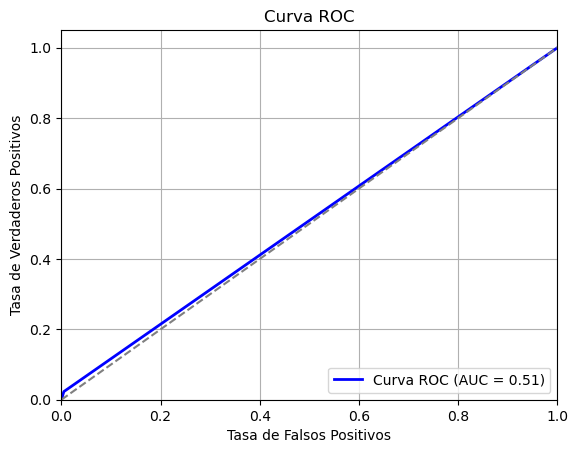

In [30]:
#Exactitud
print(f"Exactitud: {accuracy_score(y_test, final_predictions)}")

#Precision
print(f"Precision: {precision_score(y_test, final_predictions)}")

#Sensibilidad
print(f"Sensibilidad: {recall_score(y_test, final_predictions)}")

#F1
print(f"F1: {f1_score(y_test, final_predictions)}")


fpr, tpr, _ = roc_curve(y_test, final_predictions)
roc_auc = auc(fpr, tpr)
print(f"AUC: {roc_auc}")
plt.figure()
plt.plot(fpr, tpr, color="blue", lw=2, label=f"Curva ROC (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


### PRESENTACIÓN DE LA SOLUCIÓN

Guarda mejor modelo (pipeline de preparación de los datos + modelo) y  haz un script de python que te pida los datos necesarios ('int_rate', 'installment', 'fico',  'revol_bal', 'revol_util', 'inq_last_6mths', 'pub_rec' y 'purpose') y prediga la solución.

In [31]:
joblib.dump(final_model, "fully_paid.pkl")

['fully_paid.pkl']

## EJERCICIO 2

Vamos a trabajar conun conjunto de datos digits.

Crea un clasificador que nos diga de que número se trata.

### RECOPILACIÓN Y PREPARACIÓN DE LOS DATOS

#### OBTENER LOS DATOS

In [69]:
# Cargar el conjunto de datos
digits = load_digits()
X_digits = digits.data
y_digits = digits.target

#### EXPLORAR LOS DATOS

In [70]:
X_digits[0]

array([ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
       15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
       12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
        0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
       10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.])

In [71]:
X_digits.shape

(1797, 64)

In [72]:
y_digits

array([0, 1, 2, ..., 8, 9, 8])

In [73]:
y_digits.shape

(1797,)

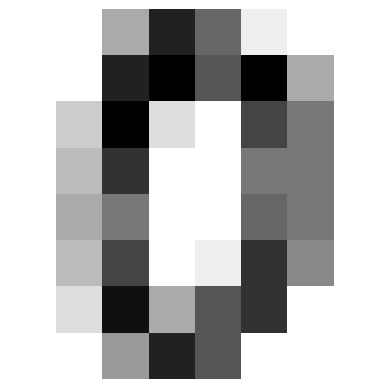

In [74]:
def plot_digit(image_data):
    image = image_data.reshape(8, 8)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

some_digit = X_digits[0]
plot_digit(some_digit)
plt.show()

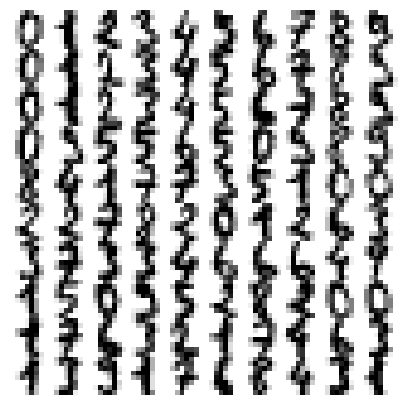

In [75]:
plt.figure(figsize=(5,5))
for idx, image_data in enumerate(X_digits[:100]):
    plt.subplot(10, 10, idx + 1)
    plot_digit(image_data)
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

#### DIVIDIR LOS DATOS

In [76]:
X_train, X_test, Y_train, Y_test = train_test_split(X_digits, y_digits, test_size=0.2, random_state=42)

#### PREPARAR LOS DATOS

In [77]:
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.fit_transform(X_test)

### ENTRENAMIENTO Y EVALUACIÓN DEL MODELO

Usa evaluación cruzada con los siguientes algoritmos, evalua los resultados en el conjunto de entrenamiento (exactitud) y calcula la matriz de confusión:
- Regresión logistica
- Maquinas de vectores de sorpote
- Random forest

Regresión logisitca
Exactitud: 0.9686847599164927



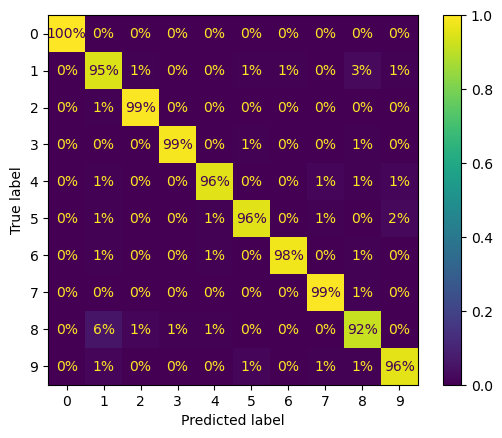

Maquinas de vectores de sorpote
Exactitud: 0.9819067501739736



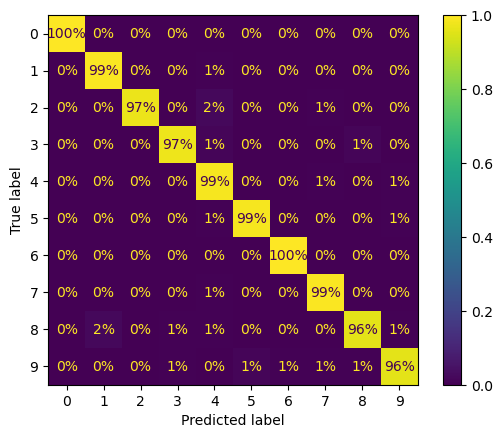

Random Forest
Exactitud: 0.97633959638135



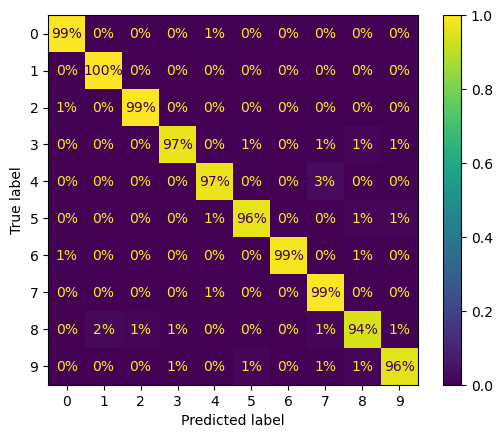

In [78]:
models={
    "Regresión logisitca": LogisticRegression(random_state=42),
    "Maquinas de vectores de sorpote":SVC(random_state=42),
    "Random Forest":RandomForestClassifier(random_state=42),
}

for name, model in models.items():
    print(name)

    #val_cruz= cross_val_score(model, x_train, y_train, cv=10, scoring="accuracy")
    predic=cross_val_predict(model, X_train_scaled, Y_train, cv=10)

    #Exactitud
    print(f"Exactitud: {accuracy_score(Y_train, predic)}")   
    print()

    #Matriz de confusion
    cm = confusion_matrix(Y_train, predic)
    ConfusionMatrixDisplay.from_predictions(Y_train, predic, normalize="true", values_format=".0%")
    plt.show()


    

### OPMITZACIÓN DEL MODELO

#### OPTIMIZACIÓN

Usa búsqueda exhaustiva o búsqueda aleatoria para optimizar el mejor modelo del apartado anterior

In [79]:
#Definir el modelo SVC
model = SVC(random_state=42)

# Hiperparámetros a ajustar
param_grid = {
    "C": [0.1, 1, 10],           # Regularización
    "kernel": ["linear", "rbf"], # Tipos de kernel
    "gamma": ["scale", "auto"]   # Coeficiente para kernels no lineales
}

# Configurar GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='accuracy')

# Ajustar el modelo (usando X_train_scaled y Y_train como ejemplo)
grid_search.fit(X_train_scaled, Y_train)

GridSearchCV(cv=3, estimator=SVC(random_state=42),
             param_grid={'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf']},
             scoring='accuracy')

#### EVALUACIÓN EN EL CONJUNTO DE PRUEBA

In [80]:
# Obtener las predicciones en el conjunto de prueba
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test_scaled)

# Calcular la precisión
accuracy = accuracy_score(Y_test, predictions)

# Resultados
print("Mejores parámetros:", grid_search.best_params_)
print("Precisión en el conjunto de prueba:", accuracy)

Mejores parámetros: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Precisión en el conjunto de prueba: 0.975


### PRESENTACIÓN DE LA SOLUCIÓN

Simplemente guarda el modelo

In [81]:
joblib.dump(final_model, "numeros.pkl")

['numeros.pkl']

## EJERCICIO 3

Vamos a trabajar con un conjunto de datos donde cada instancia (en este caso, cada película) pueda tener múltiples etiquetas (géneros en este caso).

Tienes los datos en el fichero tmdb_5000_movies.csv

Crea un clasificador que te diga los generos que le corresponden a cada película.

### RECOPILACIÓN Y PREPARACIÓN DE LOS DATOS

#### OBTENER LOS DATOS

In [82]:
# Cargar los datos
data = pd.read_csv("datos/tmdb_5000_movies.csv")

# Preprocesamiento de datos
# Transformar géneros en listas de palabras separadas
data["genres"] = data["genres"].apply(lambda x: [genre["name"] for genre in eval(x)])

# Dividir los datos en características (X) y etiquetas (y)
X = data["overview"]
y = data["genres"]

#### EXPLORAR LOS DATOS

In [83]:
X.head()

0    In the 22nd century, a paraplegic Marine is di...
1    Captain Barbossa, long believed to be dead, ha...
2    A cryptic message from Bond’s past sends him o...
3    Following the death of District Attorney Harve...
4    John Carter is a war-weary, former military ca...
Name: overview, dtype: object

In [84]:
X.info()

<class 'pandas.core.series.Series'>
RangeIndex: 4803 entries, 0 to 4802
Series name: overview
Non-Null Count  Dtype 
--------------  ----- 
4800 non-null   object
dtypes: object(1)
memory usage: 37.7+ KB


#### DIVIDIR LOS DATOS

In [87]:
X= X.dropna()
indices = X.index
y= y.loc[indices]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### PREPARAR LOS DATOS

Tienes aquí las transformaciones que hay que hacer a los datos pero busca en internet que estamos haciendo exactamente y explicalo (igual hay que hacer algo con los datos que faltan)

In [88]:
#El TfidfVectorizer es una clase de la biblioteca sklearn (Scikit-learn) que convierte un conjunto de documentos 
# de texto (como una lista de oraciones o frases) en una matriz de características numéricas.

#El MultiLabelBinarizer es una clase de Scikit-learn utilizada cuando se tiene un problema de clasificación con 
# múltiples etiquetas. En lugar de asignar solo una etiqueta a cada muestra (como en la clasificación tradicional), 
# una muestra puede tener varias etiquetas. El MultiLabelBinarizer convierte estas etiquetas múltiples en un formato 
# binario, donde cada etiqueta se convierte en una columna, y los valores son 0 o 1 dependiendo de si esa etiqueta 
# está presente o no en cada muestra.

In [89]:
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

mlb = MultiLabelBinarizer()
y_train_transformed = mlb.fit_transform(y_train)


In [90]:
y_test_transformed = mlb.transform(y_test)

### ENTRENAMIENTO Y EVALUACIÓN DEL MODELO

Crea un modelo Random Forest y evalúa el modelo en el conjunto de entrenamiento (accuracy), no hace falta usar validación cruzada.

In [92]:
random_Forest=RandomForestClassifier(n_estimators=50).fit(X_train_tfidf,y_train_transformed)

train_predictionsRF =random_Forest.predict(X_train_tfidf)
train_RF_accuracy = accuracy_score( y_train_transformed, train_predictionsRF)

test_predictionsRF =random_Forest.predict(X_test_tfidf)
test_RF_accuracy = accuracy_score(y_test_transformed, test_predictionsRF)

print(f"Train: {train_RF_accuracy}")
print(f"Test: {test_RF_accuracy}")

Train: 0.9924479166666667
Test: 0.07916666666666666


#### EVALUACIÓN EN EL CONJUNTO DE PRUEBA

Evalúa el modelo en el conjuno de prueba y muestra las primeras 25 predicciones y sus correspondientes valores reales (con texto, para lo cual tendras que aplicar mlb.inverse_transform a las predicciones).

¿Qué puedes deducir del resultado?

In [ ]:
y_test=mlb.inverse_transform(y_test_transformed)
predicciones_test=mlb.inverse_transform(random_Forest.predict(X_test_tfidf))

for i in range(25):
    print(predicciones_test[i], y_test[i])

#Parece que el modelo esta sobreajustado ya que en los datos de train es muy bueno pero a la hora de la verdad
#sus resultados son muy malos. Ademas, parece que tan solo sabe decir si son peliculas de drama y no siempre
# lo hace correctamente

() ('Action', 'Adventure', 'Comedy', 'Thriller')
('Comedy',) ('Comedy',)
() ('Comedy', 'Family')
() ('Drama',)
() ('Adventure', 'Family', 'Fantasy')
() ('Action', 'Adventure', 'Science Fiction')
() ('Action', 'Science Fiction', 'Thriller')
('Drama',) ('Comedy', 'Romance')
('Drama',) ('Comedy', 'Drama', 'Romance')
() ('Action', 'Comedy', 'Crime', 'Drama', 'Music')
('Drama',) ('Comedy', 'Romance')
('Drama',) ('Comedy', 'Family', 'Romance')
('Drama',) ('Comedy', 'Drama', 'Romance')
() ('Comedy', 'Drama', 'Family', 'Fantasy', 'Romance')
() ('Action', 'Comedy')
() ('Action', 'Fantasy', 'Horror', 'Mystery')
('Drama',) ('Drama', 'Romance')
() ('Action', 'Thriller')
('Drama',) ('Drama',)
() ('Drama',)
() ('Comedy', 'Crime')
('Romance',) ('Action', 'Comedy', 'Crime', 'Romance')
('Drama',) ('Drama',)
() ('Drama', 'Music', 'Romance')
('Drama',) ('Drama',)
